# Imports

In [55]:
import cv2
import numpy as np
import pandas as pd
import sys
import glob 
import os
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

import matplotlib.image as mpimg

# Useful Methods

In [5]:
def resize(frame, scale):
    return cv2.resize(frame, (int(frame.shape[1] * scale), int(frame.shape[0] * scale) ))

def get_features_with_label(img_data, hog, label):
    dims = (80, 80)
    data = []
    for img in img_data:
        img = cv2.resize(img, dims)
        feat = hog.compute( img[:, :, :] )
        data.append( (feat, label) )
    return data

def init_hog():
    min_dims = 80
    block_size = (16, 16)
    block_stride = (8, 8)
    cell_size = (8, 8)
    bins = 9
    dims = (80, 80)
    hog = cv2.HOGDescriptor(dims, block_size, block_stride, cell_size, bins)
    return hog


def train_svm(svm, hog, positive_images_path, negative_images_path):
    pos_imgs = []
    neg_imgs = []
    for img in glob.glob(positive_images_path):
        pos_imgs.append( cv2.imread(img) )
    for img in glob.glob(negative_images_path):
        neg_imgs.append( cv2.imread(img) )

    positive_data = get_features_with_label(pos_imgs, hog, 1)
    negative_data = get_features_with_label(neg_imgs, hog, 0)
    data_df = positive_data + negative_data
    np.random.shuffle(data_df)

    feat, labels = map(list, zip(*data_df) )
    feat_flat = [x.flatten() for x in feat]
    X_df = pd.DataFrame(feat_flat)
    y_df = pd.Series(labels)

    X_train, X_test, y_train, y_test = train_test_split(
        X_df,
        y_df,
        test_size=0.3,
        random_state=2
    )
    svm.fit(X_train, y_train)

def scaled(frame, scale): # returns new scale value
    frame_shape_x, frame_shape_y, channels = frame.shape
    if(frame_shape_x > scale):
        return scale / frame_shape_x
    else:
        return 1

def color_filter(frame, lower_upper_list):
    lower = np.array(lower_upper_list[0], dtype="uint8")
    upper = np.array(lower_upper_list[1], dtype="uint8")

    mask = cv2.inRange(frame, lower, upper)
    output = cv2.bitwise_and(frame, frame, mask = mask)

    return output, mask


def create_all_boxes(frame_contours_list):
    box_list = []
    for contour in frame_contours_list:
        cv2.boudingRect(contour)
        box_list.append(contour)
    return box_list


def filter_boxes(frame_rectangle_list, filter_size=0):
    filtered_boxes = []
    for rectangle in frame_rectangle_list:
        if(rectangle[2] * rectangle[3] > filter_size):
            filtered_boxes.append(rectangle)
    return filtered_boxes


def draw_rectangles(frame, frame_rectangle_list, x_offset=0, y_offset=0):
    for x, y, w, h in frame_rectangle_list:
        cv2.rectangle(
            frame,
            (x - x_offset, y - y_offset),
            ((x + x_offset) + w, (y + y_offset) + h),
            (0, 255, 0),
            2
        )
        
def to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

## -- file utils -- ##

# input is a path to a directory of images
# takes a directory path and returns the file names in the dir as a list
def get_file_names(imgs_path, sort=False):
    # sort will come later..
    dir_list = []
    with os.scandir(imgs_path) as it:
        for entry in it:
            if not entry.name.startswith(".") and entry.is_file:
                dir_list.append(entry.name)
        return dir_list

# input is a path to images and a list of file names
# returns a list of images
def import_images(path, img_names):
    img_list = []
    for img in img_names:
        img_list.append(cv2.imread(path + img) )
    return img_list

def square_maker(filtered_boxes):
    empty = []
    for i in filtered_boxes:
        if(i[2] > i[3]):
            diff = i[2] - i[3]
            stuff = i[3] + diff
            empty.append((i[0], i[1], i[2], stuff))
        else:
            diff = i[3] - i[2]
            stuff = i[2] + diff
            empty.append((i[0], i[1], stuff, i[3]))
    return empty

In [52]:
# different shades of  black
lower_black = np.array([0])
upper_black = np.array([64])

# lower_black = np.array([65])
# upper_black = np.array([129])

# lower_black = np.array([130])
# upper_black = np.array([194])

# lower_black = np.array([195])
# upper_black = np.array([255])

# Test to see if reading image works

In [26]:
labels = pd.read_csv('../images/labels.csv')
labels.head()

,Path,Label
0,/positive_images/new_vans-both-23.jpg,1
1,/positive_images/new_vans-outside-014.jpg,1
2,/positive_images/new_vans-inside-217.jpg,1
3,/positive_images/new_vans-outside-028.jpg,1
4,/positive_images/new_adidas-inside-238.jpg,1


In [32]:
print(labels.shape)
label = labels['Label']
label.head()

(7433, 2)


0    1
1    1
2    1
3    1
4    1
Name: Label, dtype: int64

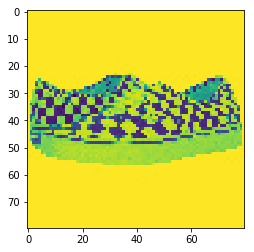

In [33]:
zero = mpimg.imread('../images/' + labels['Path'][0])
plt.imshow(zero)

# Read in training data and flatten and scale the images

In [41]:
df = pd.DataFrame()
for count, i in enumerate(labels['Path']):
    holder = mpimg.imread('../images/' + i)
    df[str(count)] = holder.flatten()
df = df.T
df.head()
print(df.shape)

(7433, 6400)


In [45]:
scale = preprocessing.scale(df)
normalized = pd.DataFrame(scale, columns = df.columns)
normalized.head()

,0,1,2,3,4,5,6,7,8,9,...,6390,6391,6392,6393,6394,6395,6396,6397,6398,6399
0,0.987243,0.987044,0.987235,0.985675,0.984536,0.980592,0.980359,0.982874,0.978562,0.979057,...,1.085935,1.084525,1.085487,1.087981,1.088486,1.089974,1.086337,1.08583,1.08563,1.085665
1,0.987243,0.987044,0.987235,0.985675,0.984536,0.980592,0.980359,0.982874,0.978562,0.979057,...,1.085935,1.084525,1.085487,1.087981,1.088486,1.089974,1.086337,1.08583,1.08563,1.085665
2,0.987243,0.987044,0.987235,0.985675,0.984536,0.980592,0.980359,0.982874,0.978562,0.979057,...,1.085935,1.084525,1.085487,1.087981,1.088486,1.089974,1.086337,1.08583,1.08563,1.085665
3,0.987243,0.987044,0.987235,0.985675,0.984536,0.980592,0.980359,0.982874,0.978562,0.979057,...,1.085935,1.084525,1.085487,1.087981,1.088486,1.089974,1.086337,1.08583,1.08563,1.085665
4,0.987243,0.987044,0.987235,0.985675,0.984536,0.980592,0.980359,0.982874,0.978562,0.979057,...,1.085935,1.084525,1.085487,1.087981,1.088486,1.089974,1.086337,1.08583,1.08563,1.085665


In [48]:
print("normalized ", normalized.shape)
print('labels, ', label.shape)

normalized  (7433, 6400)
labels,  (7433,)


# Train the model

In [51]:
X_Train, X_Test, y_Train, y_Test = train_test_split(normalized, label, test_size = 0.25)
svc = SVC(C=1, kernel='rbf', gamma=0.0005, random_state=1)
svc.fit(X_Train, y_Train)
pred = svc.predict(X_Test)
score = accuracy_score(y_Test, pred)
print("Accuracy Score: ", score)

Accuracy Score:  0.9962345346960731


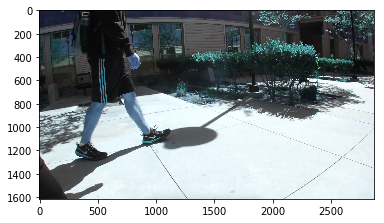

In [61]:
foot = cv2.imread('danny_foot.png')
plt.imshow(foot)
plt.show()

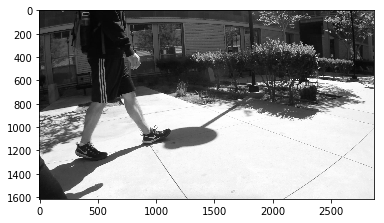

In [60]:
footGrayscaled = to_grayscale(foot)
plt.imshow(footGrayscaled, cmap='gray')
plt.show()

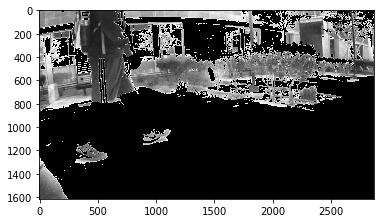

In [64]:
pimg1, mask = color_filter(footGrayscaled, [lower_black, upper_black])
plt.imshow(pimg1, cmap='gray')
plt.show()

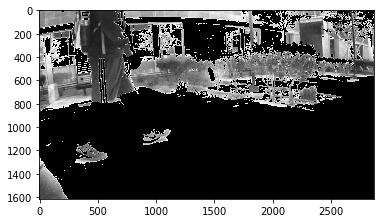

In [67]:
ret1, img1_thresh = cv2.threshold(pimg1, lower_black, upper_black, cv2.THRESH_TOZERO)
plt.imshow(img1_thresh, cmap='gray')
plt.show()

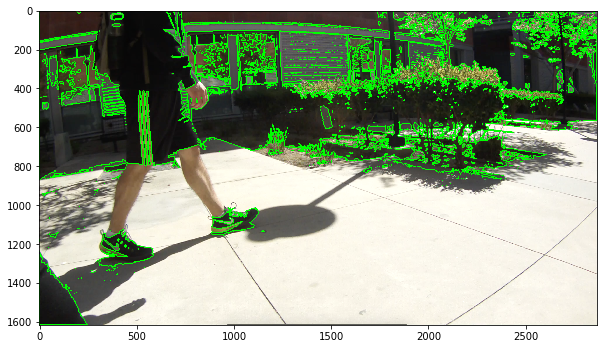

In [68]:
threshold_color = [0, 255, 0] # green

foot_copy = foot.copy()
foot_copy_copy = foot.copy()
img1_c, img1_contours, img1_heirarchy = cv2.findContours(img1_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(foot_copy, img1_contours, -1, threshold_color, 3)
plt.figure(figsize=(10, 6) )
plt.imshow(cv2.cvtColor(foot_copy, cv2.COLOR_BGR2RGB) )
plt.show()

In [69]:
upper_filter_size = 10000
lower_filter_size = 100000
# dimensions = (1080,1080)
# this gets the rectangle, will show the x y coordinate then width and height
img1_all_boxes = [cv2.boundingRect(c) for c in img1_contours]
img1_filter_boxes = filter_boxes(img1_all_boxes, upper_filter_size, lower_filter_size)
# draw_rectangles(foot_copy_copy, img1_filter_boxes, 5, 5)
square_boxes = square_maker(img1_filter_boxes)
draw_rectangles(foot_copy_copy, square_boxes)
# roi_filtered_1 = get_positive_roi(foot, img1_filter_boxes)
# draw_rectangles(foot, roi_filtered_1, 5, 5)
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(foot_copy_copy, cv2.COLOR_BGR2RGB))
plt.show()

TypeError: filter_boxes() takes from 1 to 2 positional arguments but 3 were given